In [1]:
import optuna
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np
import pandas            as pd

from sklearn.model_selection         import train_test_split
from sklearn.metrics                 import *
from sklearn.feature_extraction.text import TfidfVectorizer
from mlflow.models.signature         import infer_signature
from sklearn.linear_model            import LogisticRegression
from sklearn.svm                     import SVC
from xgboost                         import XGBClassifier
from lightgbm                        import LGBMClassifier
from sklearn.neighbors               import KNeighborsClassifier
from sklearn.naive_bayes             import MultinomialNB
from sklearn.ensemble                import RandomForestClassifier
from imblearn.over_sampling          import SMOTE

In [3]:
df = pd.read_csv('preprocessed_corpus.csv')
df.head()

,raw_comment,category,word_count_raw,char_count_raw,num_unique_words,num_upper_words,num_punctuation_raw,cleaned_comment,num_stop_words,processed_comment,final_word_count,final_char_count
0,family mormon have never tried explain them t...,1,39,261,34,0,0,family mormon have never tried explain them th...,13,family mormon never tried explain still stare ...,26,171
1,buddhism has very much lot compatible with chr...,1,196,1269,136,0,0,buddhism has very much lot compatible with chr...,56,buddhism much lot compatible christianity espe...,140,842
2,seriously don say thing first all they won get...,-1,86,460,67,0,0,seriously don say thing first all they won get...,40,seriously say thing first get complex explain ...,46,230
3,what you have learned yours and only yours wha...,0,29,168,24,0,0,what you have learned yours and only yours wha...,14,learned want teach different focus goal not wr...,15,87
4,for your own benefit you may want read living ...,1,112,691,82,0,0,for your own benefit you may want read living ...,46,benefit may want read living buddha living chr...,66,397


In [5]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-13-201-96-130.ap-south-1.compute.amazonaws.com:5000/")

In [7]:
# # create an experiment 
# mlflow.create_experiment(
#                             name              = "Experiment_5_xgboost_with_hpt",
#                             artifact_location = "s3://mlflow-s3-25/Experiment_5_xgboost_with_hpt"
#                         )

In [9]:
# set an experiment
mlflow.set_experiment("Experiment_5_xgboost_with_hpt")

<Experiment: artifact_location='s3://mlflow-s3-25/Experiment_5_xgboost_with_hpt', creation_time=1756969496541, experiment_id='992315398862381677', last_update_time=1756969496541, lifecycle_stage='active', name='Experiment_5_xgboost_with_hpt', tags={}>

In [11]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
df['category']       = df['category'].map({-1: 2, 0: 0, 1: 1})

# Step 4: Train-test split before vectorization and resampling
X_train, X_test, y_train, y_test = train_test_split(df['processed_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# Step 2: Vectorization using TF-IDF, fit on training data only
ngram_range          = (1, 3)                                    # Trigram setting
max_features         = 1000                                      # Set max_features to 1000 for TF-IDF

vectorizer           = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X_train_vec          = vectorizer.fit_transform(X_train)          # Fit on training data
X_test_vec           = vectorizer.transform    (X_test)           # Transform test data

smote                = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [13]:
# Function to log results in MLflow
def log_mlflow(model_name, model, X_train, X_test, y_train, y_test, params):
    with mlflow.start_run() as run:
        # Log model type
        mlflow.set_tag("mlflow.runName",  f"{model_name}_SMOTE_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")

        # Log algorithm name as a parameter
        mlflow.log_param("Algorithm_name", model_name)
        # Log hyperparameters
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Train model
        model.fit(X_train, y_train)

        # Step 6: Make predictions and log metrics
        y_pred             = model.predict(X_test_vec)

        # Step 5: Compute Evaluation Metrics
        accuracy           = accuracy_score       (y_test, y_pred)
        
        macro_precision    = precision_score      (y_test, y_pred, average='macro')
        macro_recall       = recall_score         (y_test, y_pred, average='macro')            # Recall or Sensitivity
        macro_F1_score     = f1_score             (y_test, y_pred, average='macro')
        macro_roc_auc      = roc_auc_score        (y_test, model.predict_proba(X_test_vec), average='macro', multi_class='ovr')
        weighted_precision = precision_score      (y_test, y_pred, average='weighted')
        weighted_recall    = recall_score         (y_test, y_pred, average='weighted')         # Recall or Sensitivity
        weighted_F1_score  = f1_score             (y_test, y_pred, average='weighted')
        weighted_roc_auc   = roc_auc_score        (y_test, model.predict_proba(X_test_vec), average='weighted', multi_class='ovr')
        
        log_loss_value     = log_loss             (y_test, model.predict_proba(X_test_vec))
        cm                 = confusion_matrix     (y_test, y_pred)
        cr                 = classification_report(y_test, y_pred)
        
        # Step 7: Log Class-wise Metrics from Classification Report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)

        for label, metrics in classification_rep.items():
            clean_label    = label.replace(" avg", "")                   # Remove " avg" from label if present
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{clean_label}_{metric}", value)  
            else:
                mlflow.log_metric(f"{clean_label}", metrics)             # Logs accuracy metric
        
        # Step 6: Log Remaining Metrics to MLflow
        mlflow.log_metric("log_loss",         log_loss_value)        
        mlflow.log_metric("macro_roc_auc",    macro_roc_auc)
        mlflow.log_metric("weighted_roc_auc", weighted_roc_auc)
        
        # Step 8: Plot and Log Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix : {model_name}_model")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
    
        # Step 9: saving and logging the dataset
        df.to_csv("dataset.csv", index=False)
        mlflow.log_artifact("dataset.csv")
        
        # Step 10: Log Model and Dataset
        input_example = X_test_vec[:5]                                           # input_example provides a sample input for the model, 
                                                                                 # useful for UI display and validation
        signature     = infer_signature(X_train_vec, model.predict(X_train_vec)) # signature defines the expected input/output schema of the model, 
                                                                                 # enabling reproducibility and serving
        
        mlflow.sklearn.log_model(
                                    sk_model      = model,
                                    name          = f"{model_name}_model",
                                    input_example = input_example,
                                    signature     = signature
                                ) 
        # Step 11: Print Evaluation Summary
        print(f"\033[1m\033[4mEvaluation Metrics : {model_name}_model\033[0m : (values close to 1 represent the GOOD Model)\n")
        print(f'\tAccuracy     : {accuracy:.2f}    --> [TP + TN]/ALL       : The proportion of correctly predicted observations over total predictions')
        print(f'\tLog Loss     : {log_loss_value:.2f}    --> Measures the performance of a classification model, Less is Good')
        print(f'\t\033[1m\033[4mMacro\033[0m  \t\t       --> Macro average       : Treats all classes equally by computing the unweighted mean of per-class metrics')
        print(f'\t  Precision  : {macro_precision:.2f}    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions ')
        print(f'\t  Recall     : {macro_recall:.2f}    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.')
        print(f'\t  F1-Score   : {macro_F1_score:.2f}    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences')
        print(f'\t  ROC-AUC    : {macro_roc_auc:.2f}    --> Measures the ability of the model to distinguish between classes.')
        
        print(f'\t\033[1m\033[4mWeighted\033[0m  \t       --> Weighted average    : Accounts for class imbalance by weighting each class metric by its support')
        print(f'\t  Precision  : {weighted_precision:.2f}    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions ')
        print(f'\t  Recall     : {weighted_recall:.2f}    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.')
        print(f'\t  F1-Score   : {weighted_F1_score:.2f}    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences')
        print(f'\t  ROC-AUC    : {weighted_roc_auc:.2f}    --> Measures the ability of the model to distinguish between classes.')
        
        
        print(f'\nConfusion Matix      :         -->    \033[1m\033[4mORIGINAL\033[0m     \t\t\033[1m\033[4mSTANDARD\033[0m\n')
        def format_row(row):
            formatted = ' '.join(f"{val:>2}" for val in row)
            return f"[{formatted}]"
        
        for row1, row2 in zip(cm, np.flip(cm)):
            print("\t\t\t\t  ", format_row(row1), "\t       ", format_row(row2))
        
        print("\nClassification Rpt   :")
        print('\n'.join('\t\t\t\t' + line for line in cr.splitlines()))





# Step 6: Optuna objective function for XGBoost
def objective_xgboost(trial):
    n_estimators  = trial.suggest_int   ('n_estimators',  50, 300)                    # it uses Bayesian optimization  to intelligently sample values based on past trial performance
    learning_rate = trial.suggest_float ('learning_rate', 1e-4, 1e-1, log=True)       # Suggest learning rate on a logarithmic scale for fine-grained tuning
    max_depth     = trial.suggest_int   ('max_depth',     3, 10)                      # Suggest maximum tree depth to control model complexity

    model         = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    
    return accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))# Train the model and return accuracy on the test set as the optimization target


# Run Optuna hyperparameter optimization for xgboost and log the best model only
def run_optuna_experiment():
    study         = optuna.create_study(direction="maximize")                         # Create an Optuna study to maximize accuracy
    study.optimize(objective_xgboost, n_trials=30)                                    # Run optimization for 30 trials using the objective function


    best_params   = study.best_params                                                 # Retrieve the best hyperparameters from the study
    best_model    = XGBClassifier(                                                    # Rebuild the model using the best-found parameters
                                    n_estimators   = best_params['n_estimators'],
                                    learning_rate  = best_params['learning_rate'], 
                                    max_depth      = best_params['max_depth'], 
                                    random_state   = 42
                                 )

    return study, best_model                                                                    

In [15]:
# Run the experiment for XGBoost
study, best_model = run_optuna_experiment()

[I 2025-09-04 17:52:12,551] A new study created in memory with name: no-name-3ff7324d-5e1d-4eb5-a735-a3d4ac7675bf
[I 2025-09-04 17:52:35,394] Trial 0 finished with value: 0.5807860262008734 and parameters: {'n_estimators': 73, 'learning_rate': 0.0006807162232872763, 'max_depth': 8}. Best is trial 0 with value: 0.5807860262008734.
[I 2025-09-04 17:52:53,765] Trial 1 finished with value: 0.6176310043668122 and parameters: {'n_estimators': 81, 'learning_rate': 0.013671677912455068, 'max_depth': 6}. Best is trial 1 with value: 0.6176310043668122.
[I 2025-09-04 17:53:36,290] Trial 2 finished with value: 0.6735807860262009 and parameters: {'n_estimators': 156, 'learning_rate': 0.023482003998703916, 'max_depth': 7}. Best is trial 2 with value: 0.6735807860262009.
[I 2025-09-04 17:54:04,247] Trial 3 finished with value: 0.5346615720524017 and parameters: {'n_estimators': 188, 'learning_rate': 0.0001223507410900021, 'max_depth': 5}. Best is trial 2 with value: 0.6735807860262009.
[I 2025-09-04 

Evaluation Metrics : XGBoost_model : (values close to 1 represent the GOOD Model)

	Accuracy     : 0.77    --> [TP + TN]/ALL       : The proportion of correctly predicted observations over total predictions
	Log Loss     : 0.61    --> Measures the performance of a classification model, Less is Good
	Macro  		       --> Macro average       : Treats all classes equally by computing the unweighted mean of per-class metrics
	  Precision  : 0.76    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions 
	  Recall     : 0.76    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.
	  F1-Score   : 0.75    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences
	  ROC-AUC    : 0.88    --> Measures the ability of the model to distinguish between classes.
	Weighted  	       --> Weighted average    : Accounts for class imbalance by weighting each class metric by 

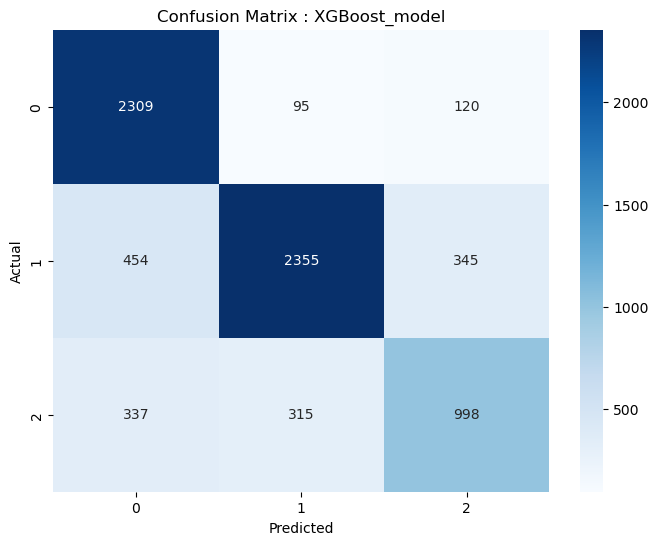

In [16]:
# Log the best model and its performance to MLflow, passing the algo_name as "xgboost"
log_mlflow("XGBoost", best_model, X_train_vec, X_test_vec, y_train, y_test, study.best_params)

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\plotly\io\_renderers.py:51: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.7 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



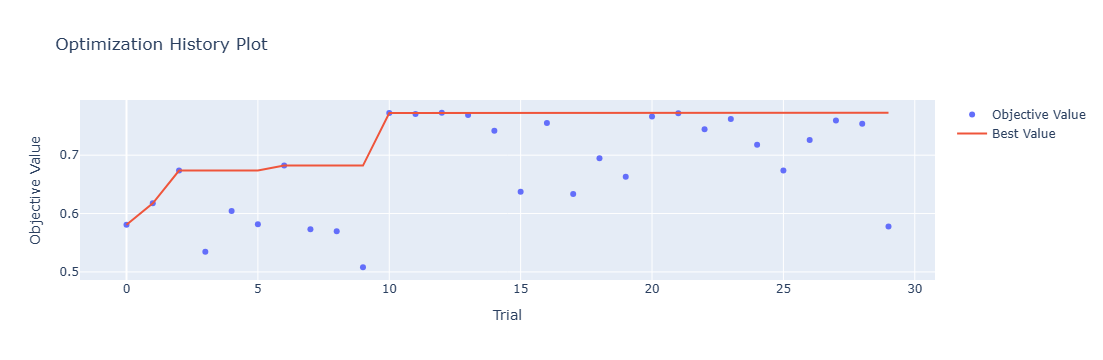

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\plotly\io\_renderers.py:51: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.7 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



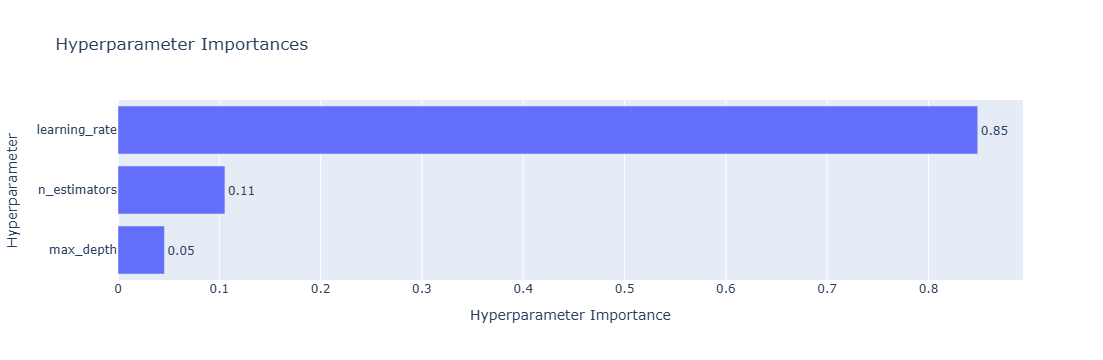

In [17]:
# Visualize optimization history and parameter importance
import plotly

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances   (study).show()